# Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
wego = pd.read_csv('../data/Headway Data, 8-1-2023 to 9-30-2023.csv')

In [3]:
wego.shape

(350329, 30)

In [4]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES'],
      dtype='object')

## create unique trip id

In [5]:
def create_id(row):
    row['CALENDAR_ID'] + ''

In [6]:
wego['DATE_TRIP'] = wego.apply(lambda row: str(row['CALENDAR_ID']) + '-' + str(row['TRIP_ID']), axis=1)

In [7]:
wego['DATE_TRIP'].nunique()

67370

### Create Headway Categories

In [8]:
# Calculate HDWY Deviation Percentage
def get_dev_pct(row):
    '''Takes a row as input, returns a perfencate value. 
    Calculate the headway deviation percentage taking into
    consideration the possibility of SCHEDULED_HDWY being 0'''
    if row['SCHEDULED_HDWY'] != 0:
        return abs(row['HDWY_DEV']) / row['SCHEDULED_HDWY'] * 100
    else:
        return np.NaN

In [9]:
# create headway deviation percentable column
wego.loc[:, 'HDWY_DEV_PCT'] = wego.apply(lambda r: get_dev_pct(r), axis=1)

In [10]:
# Create Bunching or Gapping Indicator
def is_hdwy_bunching(dev, pct):
    if (dev < 0) & (pct > 50):
        return int(1)
    else:
        return int(0)
def is_hdwy_gapping(dev, pct):
    if (dev > 0) & (pct > 50):
        return int(1)
    else:
        return int(0)
def is_hdwy_acceptable(pct):
    if pct <= 50:
        return int(1)
    else:
        return int(0)

In [11]:
# Create new Bunching/gapping columns with Boolean values for each group.
wego.loc[:, 'HDWY_BUNCHING'] = wego.apply(lambda r: 
                                          is_hdwy_bunching(r['HDWY_DEV'], r['HDWY_DEV_PCT']), axis=1)
wego.loc[:, 'HDWY_ACCEPTABLE'] = wego.apply(lambda r: 
                                            is_hdwy_acceptable(r['HDWY_DEV_PCT']), axis=1)
wego.loc[:, 'HDWY_GAPPING'] = wego.apply(lambda r: 
                                         is_hdwy_gapping(r['HDWY_DEV'], r['HDWY_DEV_PCT']), axis=1)

# 1) What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like? 

In [12]:
round(wego['ADJUSTED_ONTIME_COUNT'].value_counts()[1] / wego.shape[0] * 100, 2)

77.08

#### 77% of checkins here considered ontime.

In [13]:
trips_adherence_cat = (wego.groupby('DATE_TRIP')
.sum()
[['ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT']])

In [14]:
perfect_trips = (trips_adherence_cat[
    (trips_adherence_cat['ADJUSTED_EARLY_COUNT'] == 0) & 
    (trips_adherence_cat['ADJUSTED_LATE_COUNT'] == 0)])

In [15]:
round(perfect_trips.shape[0] / trips_adherence_cat.shape[0] * 100, 2)

60.62

In [16]:
perfect_trips.shape[0]

40843

#### 60.6% of all trips were perfect, 40843 perfect trips

In [17]:
wego['ADHERENCE'].apply(['min', 'max', 'mean', 'median'])

min      -948.533333
max        88.383333
mean       -3.188796
median     -2.000000
Name: ADHERENCE, dtype: float64

In [18]:
wego['HDWY_DEV'].apply(['min', 'max', 'mean', 'median'])

min       -64.000000
max       565.433333
mean        0.518081
median      0.033333
Name: HDWY_DEV, dtype: float64

In [19]:
# Calculate Adherence mean and standard deviation
ad_mean = wego['ADHERENCE'].mean()
ad_std = np.std(wego['ADHERENCE'])

[Text(0.5, 1.0, 'Adherence Distribution Excluding Outliers'),
 Text(0.5, 0, 'Adherence')]

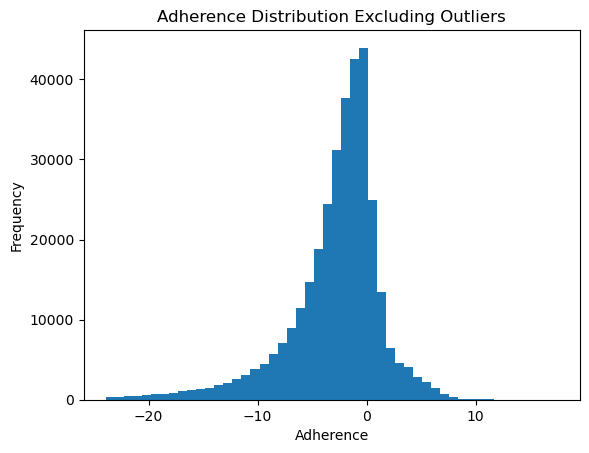

In [20]:
ax = (
    wego[wego['ADHERENCE'].between(ad_mean - ad_std*3,
                                   ad_mean + ad_std*3,
                                   inclusive='both')]
    ['ADHERENCE']
    .plot(kind='hist',
          bins=50)
)

ax.set(
    title='Adherence Distribution Excluding Outliers',
    xlabel='Adherence'
    )

In [21]:
# Calculate Headway Deviation mean and standard deviation
hd_mean = wego['HDWY_DEV'].mean()
hd_std = np.std(wego['HDWY_DEV'])

[Text(0.5, 1.0, 'Headway Deviation Distribution Excluding Outliers'),
 Text(0.5, 0, 'Headway Deviation')]

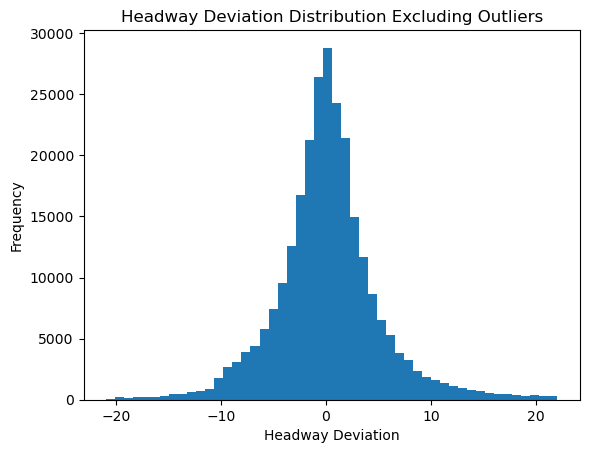

In [22]:
ax= (
    wego[wego['HDWY_DEV'].between(hd_mean - hd_std*3, 
                                  hd_mean + hd_std*3, 
                                  inclusive='both')]
    ['HDWY_DEV']
    .plot(kind='hist', bins=50)
)

ax.set(
    title='Headway Deviation Distribution Excluding Outliers',
    xlabel='Headway Deviation'
    )

# 2) How does direction of travel, route, or location affect the headway and on-time performance?

In [23]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'DATE_TRIP', 'HDWY_DEV_PCT',
       'HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING'],
      dtype='object')

### Route Direction

#### Headway

In [25]:
# Create new df for Headway columns grouped by Route Direction
route_direction_totals = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
         .sum()
)

In [26]:
# Create new total column for each row
route_direction_totals['TOTALS'] = route_direction_totals.sum(axis=1)

In [27]:
# Create new percentage column for each category
route_direction_totals.loc[:, 'BUNCHING_PCT'] = (route_direction_totals['HDWY_BUNCHING'] / 
                                                route_direction_totals['TOTALS'] * 100)
route_direction_totals.loc[:, 'ACCEPTABLE_PCT'] = (route_direction_totals['HDWY_ACCEPTABLE'] / 
                                                    route_direction_totals['TOTALS'] * 100)
route_direction_totals.loc[:, 'GAPPING_PCT'] = (route_direction_totals['HDWY_GAPPING'] / 
                                                    route_direction_totals['TOTALS'] * 100)

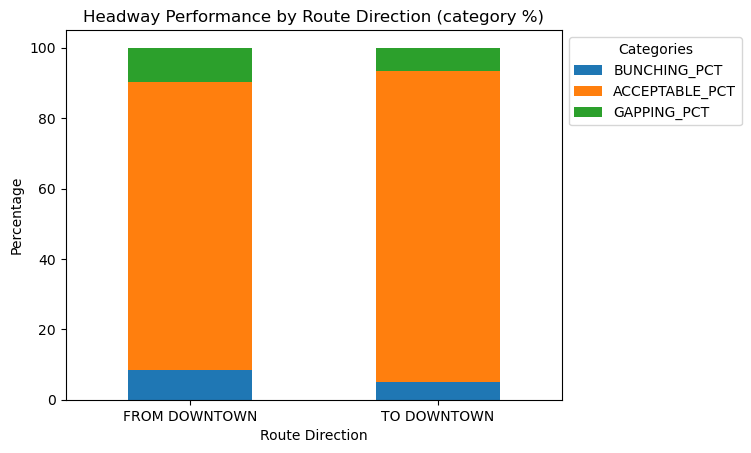

In [29]:
# Route Direction Headway Graph
ax = (route_direction_totals[['BUNCHING_PCT', 'ACCEPTABLE_PCT', 'GAPPING_PCT']]
      .plot(kind='bar',
            stacked=True))

ax.set(title = 'Headway Performance by Route Direction (category %)',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(title = 'Categories', bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

#### Adherence

In [30]:
# Create new df for Headway columns grouped by Route Direction
route_ad_direction_totals = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

In [34]:
# Create new total column for each row
route_ad_direction_totals['TOTALS'] = route_ad_direction_totals.sum(axis=1)

In [35]:
# Create new percentage column for each category
route_ad_direction_totals.loc[:, 'ONTIME_PCT'] = (route_ad_direction_totals['ADJUSTED_ONTIME_COUNT'] / 
                                                  route_ad_direction_totals['TOTALS'] * 100)
route_ad_direction_totals.loc[:, 'EARLY_PCT'] = (route_ad_direction_totals['ADJUSTED_EARLY_COUNT'] / 
                                                 route_ad_direction_totals['TOTALS'] * 100)
route_ad_direction_totals.loc[:, 'LATE_PCT'] = (route_ad_direction_totals['ADJUSTED_LATE_COUNT'] / 
                                                  route_ad_direction_totals['TOTALS'] * 100)

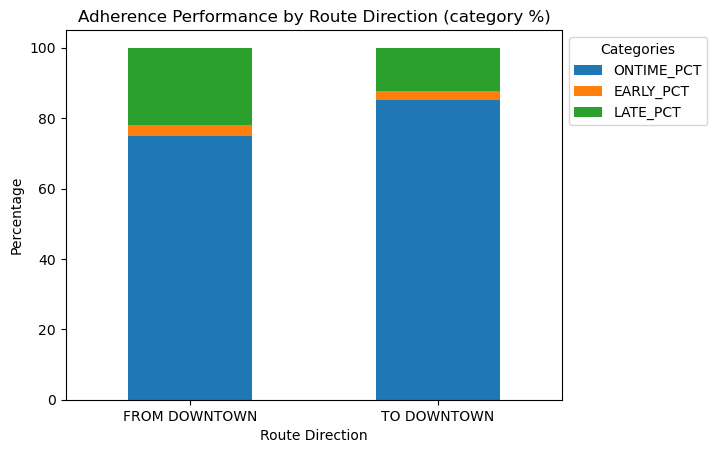

In [36]:
# Route Direction Adherence graph
ax = (
    route_ad_direction_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).plot(kind='bar', stacked=True)
ax.set(title = 'Adherence Performance by Route Direction (category %)',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(title = 'Categories', bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

In [37]:
wego.groupby('ROUTE_DIRECTION_NAME')[['HDWY_DEV_PCT', 'ADHERENCE']].mean()

,HDWY_DEV_PCT,ADHERENCE
ROUTE_DIRECTION_NAME,,
FROM DOWNTOWN,29.216261,-3.960287
TO DOWNTOWN,22.179487,-2.321804


#### TO DOWNTOWN direction has a slightly better Headway Deviation and Adherence performance

### ROUTE Performance

In [39]:
wego.groupby('ROUTE_ABBR')[['ADHERENCE', 'HDWY_DEV']].mean()

,ADHERENCE,HDWY_DEV
ROUTE_ABBR,,
3,-3.761491,0.580907
7,-3.346555,0.336808
22,-1.138107,0.955867
23,-1.760110,1.053563
50,-2.505022,0.212376
52,-3.971342,0.974776
55,-4.823302,0.261038
56,-2.703988,0.149213


#### Route 22 has better overall Adherence while route 56 has better headway deviation

### Route Adherence

In [40]:
# Create new df for Adherence columns grouped by Route
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

In [41]:
# Create new total column for each row
routes_totals['TOTALS'] = routes_totals.sum(axis=1)

In [42]:
# Create new percentage column for each category
routes_totals.loc[:, 'ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals.loc[:, 'EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals.loc[:, 'LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

In [43]:
routes_totals

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,TOTALS,ONTIME_PCT,EARLY_PCT,LATE_PCT
ROUTE_ABBR,,,,,,,
3,34516,9590,1382,45488,75.879353,3.038164,21.082483
7,13417,3417,433,17267,77.703133,2.507674,19.789193
22,22492,2065,631,25188,89.296490,2.505161,8.198348
23,35137,3230,1286,39653,88.611202,3.243134,8.145664
50,36309,5113,1207,42629,85.174412,2.831406,11.994182
52,37736,10038,1553,49327,76.501713,3.148377,20.349910
55,42080,16748,1531,60359,69.716198,2.536490,27.747312
56,48361,8837,1752,58950,82.037320,2.972010,14.990670


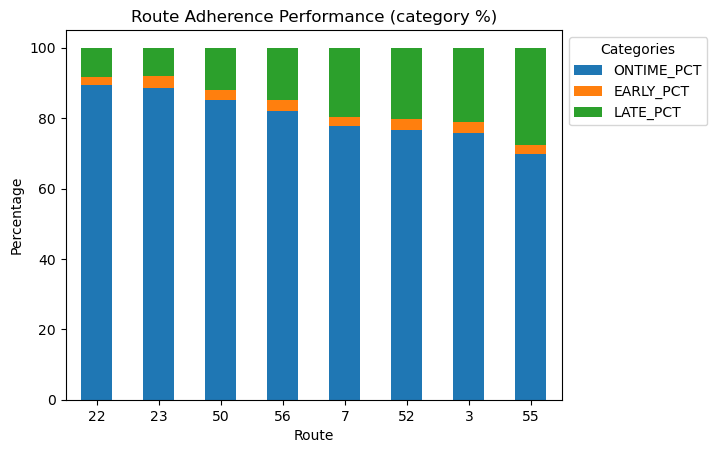

In [45]:
# Route Adherence graph
ax = (routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True)
ax.set(title = 'Route Adherence Performance (category %)',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.tick_params(axis='x', rotation=0)

### Route Headway

In [51]:
# Create new df for Headway columns grouped by Route
routes_hdwy_totals = (
    wego.groupby('ROUTE_ABBR')
         [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
         .sum()
)

In [52]:
# Create new total column for each row
routes_hdwy_totals['TOTALS'] = routes_hdwy_totals.sum(axis=1)

In [53]:
# Create new percentage column for each category
routes_hdwy_totals.loc[:, 'BUNCHING_PCT'] = routes_hdwy_totals['HDWY_BUNCHING'] / routes_hdwy_totals['TOTALS'] * 100
routes_hdwy_totals.loc[:, 'ACCEPTABLE_PCT'] = routes_hdwy_totals['HDWY_ACCEPTABLE'] / routes_hdwy_totals['TOTALS'] * 100
routes_hdwy_totals.loc[:, 'GAPPING_PCT'] = routes_hdwy_totals['HDWY_GAPPING'] / routes_hdwy_totals['TOTALS'] * 100

In [54]:
routes_hdwy_totals

,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,TOTALS,BUNCHING_PCT,ACCEPTABLE_PCT,GAPPING_PCT
ROUTE_ABBR,,,,,,,
3,2179,31460,2944,36583,5.956319,85.996228,8.047454
7,463,10500,615,11578,3.998964,90.689238,5.311798
22,297,15971,739,17007,1.746340,93.908391,4.345270
23,730,25802,1946,28478,2.563382,90.603273,6.833345
50,1056,32129,1397,34582,3.053612,92.906714,4.039674
52,3009,33050,3828,39887,7.543811,82.859077,9.597112
55,6569,36379,6468,49416,13.293265,73.617857,13.088878
56,3696,40627,3993,48316,7.649640,84.086017,8.264343


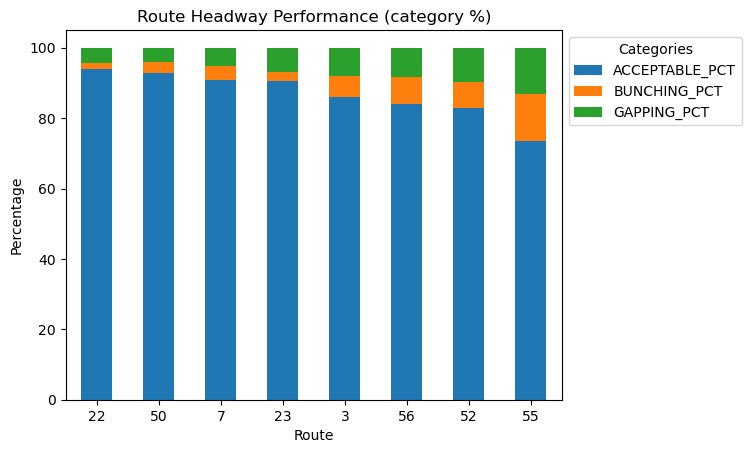

In [56]:
# Route Headway graph
ax = (routes_hdwy_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar', stacked=True)
ax.set(title = 'Route Headway Performance (category %)',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.tick_params(axis='x', rotation=0)

### Adherence by location

In [59]:
wego.groupby('TIME_POINT_ABBR')[['ADHERENCE', 'HDWY_DEV']].mean().sort_values('ADHERENCE', ascending=True)

,ADHERENCE,HDWY_DEV
TIME_POINT_ABBR,,
MCC5_11,-37.570714,NaN
MCC4_20,-13.356229,NaN
MCC5_12,-9.785042,NaN
MCC5_7,-9.075463,NaN
DCSCC,-7.091481,12.054055
...,...,...
HEAD,1.013657,NaN
MCC5_2,1.252623,NaN
25ACLARK,1.458553,0.551163


In [62]:
# Create new df for Adherence columns grouped by Location
location_totals = (
    wego.groupby('TIME_POINT_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

In [63]:
# Create new total column for each row
location_totals['TOTALS'] = location_totals.sum(axis=1)

In [64]:
# Create new percentage column for each category
location_totals.loc[:, 'ONTIME_PCT'] = location_totals['ADJUSTED_ONTIME_COUNT'] / location_totals['TOTALS'] * 100
location_totals.loc[:, 'EARLY_PCT'] = location_totals['ADJUSTED_EARLY_COUNT'] / location_totals['TOTALS'] * 100
location_totals.loc[:, 'LATE_PCT'] = location_totals['ADJUSTED_LATE_COUNT'] / location_totals['TOTALS'] * 100

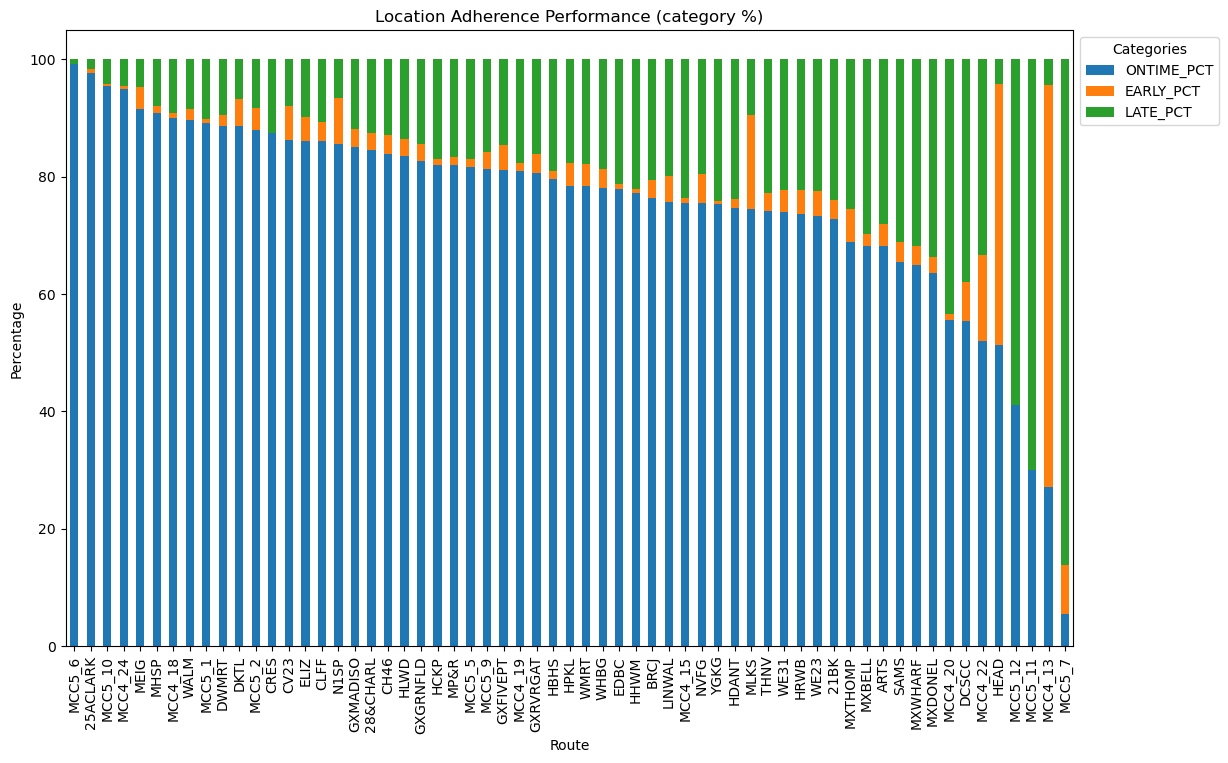

In [65]:
# Location Adherence graph
ax = (location_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True, figsize=(13, 8))
ax.set(title = 'Location Adherence Performance (category %)',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
# ax.tick_params(axis='x', rotation=0)

### Headway by Location

In [66]:
# Create new df for Headway columns grouped by Location
location_hdwy_totals = (
    wego.groupby('TIME_POINT_ABBR')
         [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
         .sum()
)

In [67]:
# Create new total column for each row
location_hdwy_totals['TOTALS'] = location_hdwy_totals.sum(axis=1)

In [68]:
# Create new percentage column for each category
location_hdwy_totals.loc[:, 'BUNCHING_PCT'] = location_hdwy_totals['HDWY_BUNCHING'] / location_hdwy_totals['TOTALS'] * 100
location_hdwy_totals.loc[:, 'ACCEPTABLE_PCT'] = location_hdwy_totals['HDWY_ACCEPTABLE'] / location_hdwy_totals['TOTALS'] * 100
location_hdwy_totals.loc[:, 'GAPPING_PCT'] = location_hdwy_totals['HDWY_GAPPING'] / location_hdwy_totals['TOTALS'] * 100

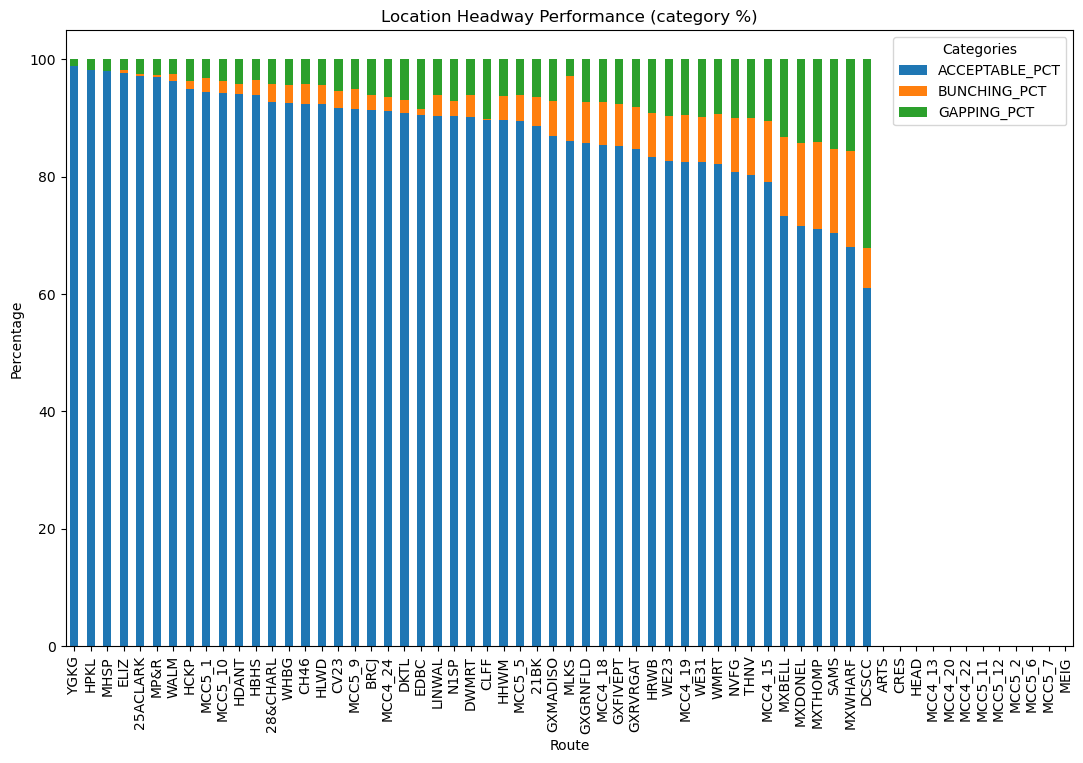

In [69]:
# Location Adherence graph
ax = (location_hdwy_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
            ).sort_values('ACCEPTABLE_PCT', ascending=False)
            .plot(kind='bar', stacked=True, figsize=(13, 8))
    
ax.set(title = 'Location Headway Performance (category %)',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
# ax.tick_params(axis='x', rotation=0)

# 3) How does time of day or day of week affect headway and on-time performance?

#### Box plots?

In [70]:
# Drop na depart times
clean_dept_time = wego.dropna(subset=['ACTUAL_DEPARTURE_TIME'])

In [71]:
clean_dept_time['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],
                                          format='mixed').dt.hour)

C:\Users\derek\AppData\Local\Temp\ipykernel_30804\1395973387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dept_time['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],


In [72]:
clean_dept_time.groupby('HOUR')[['ADHERENCE', 'HDWY_DEV']].mean()

,ADHERENCE,HDWY_DEV
HOUR,,
0,-4.478019,0.905051
1,-10.618182,4.021621
4,-0.785533,-0.771043
5,-0.966710,0.306431
6,-1.501108,0.347326
7,-2.691298,0.700018
8,-3.758128,0.413859
9,-2.611876,0.265547
10,-2.117932,0.314521


### Adherence by Hour

In [129]:
# Create new df for Adherence columns grouped by Hour
hour_totals = (
    clean_dept_time.groupby('HOUR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)


In [130]:
# Create new total column for each row
hour_totals['TOTALS'] = hour_totals.sum(axis=1)

In [131]:
# Create new percentage column for each category
hour_totals.loc[:, 'ONTIME_PCT'] = hour_totals['ADJUSTED_ONTIME_COUNT'] / hour_totals['TOTALS'] * 100
hour_totals.loc[:, 'EARLY_PCT'] = hour_totals['ADJUSTED_EARLY_COUNT'] / hour_totals['TOTALS'] * 100
hour_totals.loc[:, 'LATE_PCT'] = hour_totals['ADJUSTED_LATE_COUNT'] / hour_totals['TOTALS'] * 100

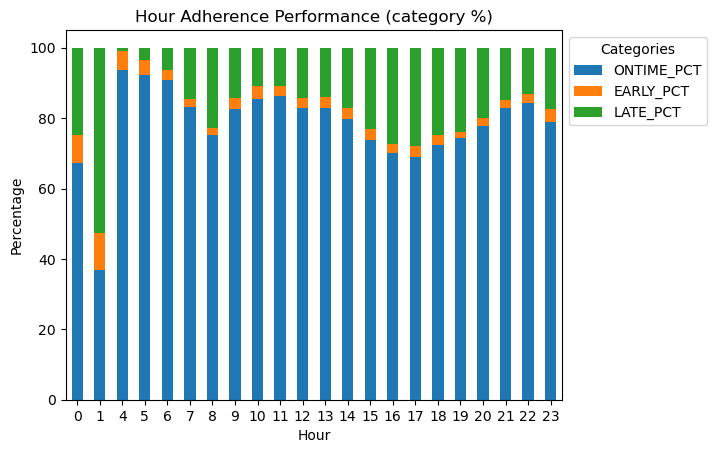

In [132]:
# Hour Adherence graph
ax = (hour_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).plot(kind='bar', stacked=True)
ax.set(title = 'Hour Adherence Performance (category %)',
        xlabel = 'Hour',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.tick_params(axis='x', rotation=0)

### Headway by Hour

In [83]:
# Create new df for Headway columns grouped by Hour
hour_hdwy_totals = (
    clean_dept_time.groupby('HOUR')
         [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
         .sum()
)

In [84]:
# Create new total column for each row
hour_hdwy_totals['TOTALS'] = hour_hdwy_totals.sum(axis=1)

In [85]:
# Create new percentage column for each category
hour_hdwy_totals.loc[:, 'BUNCHING_PCT'] = hour_hdwy_totals['HDWY_BUNCHING'] / hour_hdwy_totals['TOTALS'] * 100
hour_hdwy_totals.loc[:, 'ACCEPTABLE_PCT'] = hour_hdwy_totals['HDWY_ACCEPTABLE'] / hour_hdwy_totals['TOTALS'] * 100
hour_hdwy_totals.loc[:, 'GAPPING_PCT'] = hour_hdwy_totals['HDWY_GAPPING'] / hour_hdwy_totals['TOTALS'] * 100

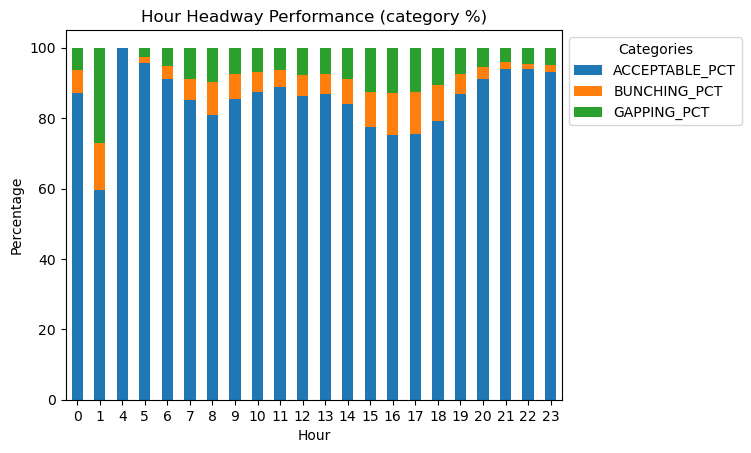

In [89]:
# Hour Headway graph
ax = (hour_hdwy_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).plot(kind='bar', stacked=True)
ax.set(title = 'Hour Headway Performance (category %)',
        xlabel = 'Hour',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.tick_params(axis='x', rotation=0)

## Weekday

#### Monday is 0

In [90]:
# Create Weekday column
clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME']).dt.weekday

C:\Users\derek\AppData\Local\Temp\ipykernel_30804\3419957694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME']).dt.weekday


In [96]:
# use Grouper to group by Weekday
wego_by_day = (clean_dept_time.groupby(pd.Grouper(key='WEEKDAY')))

## Adherence by Weekday

In [99]:
# Create new df for Adherence columns grouped by Weekday
weekday_totals = (
    wego_by_day
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

In [101]:
# Create new total column for each row
weekday_totals['TOTALS'] = weekday_totals.sum(axis=1)

In [102]:
# Create new percentage column for each category
weekday_totals.loc[:, 'ONTIME_PCT'] = weekday_totals['ADJUSTED_ONTIME_COUNT'] / weekday_totals['TOTALS'] * 100
weekday_totals.loc[:, 'EARLY_PCT'] = weekday_totals['ADJUSTED_EARLY_COUNT'] / weekday_totals['TOTALS'] * 100
weekday_totals.loc[:, 'LATE_PCT'] = weekday_totals['ADJUSTED_LATE_COUNT'] / weekday_totals['TOTALS'] * 100

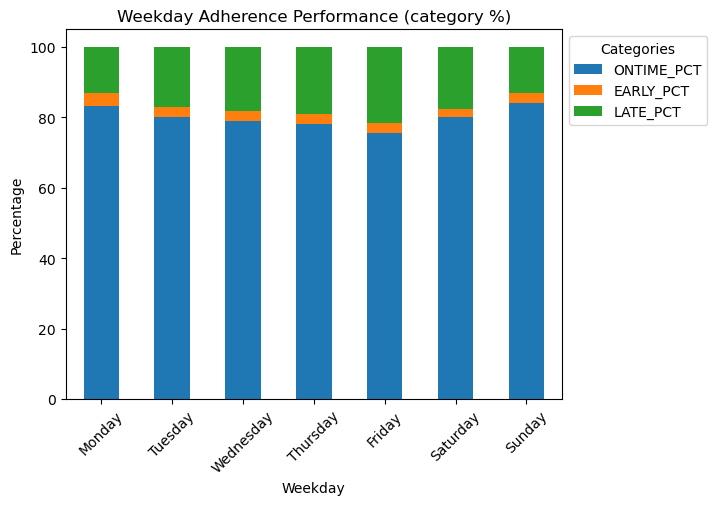

In [112]:
# Hour Adherence graph
ax = (weekday_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
                ).sort_index().plot(kind='bar', stacked=True)

ax.set(title = 'Weekday Adherence Performance (category %)',
        xlabel = 'Weekday',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)

### Headway by Weekday

In [114]:
# Create new df for Headway columns grouped by Weekday
weekday_hdwy_totals = (
    wego_by_day
         [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
         .sum()
)

In [115]:
# Create new total column for each row
weekday_hdwy_totals['TOTALS'] = weekday_hdwy_totals.sum(axis=1)

In [120]:
weekday_hdwy_totals

,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,TOTALS,BUNCHING_PCT,ACCEPTABLE_PCT,GAPPING_PCT
WEEKDAY,,,,,,,
1,3221,37104,3806,44131,7.298724,84.076953,8.624323
3,3532,36391,4278,44201,7.990769,82.330716,9.678514
2,3447,37217,3934,44598,7.729046,83.449930,8.821023
4,3986,35014,4867,43867,9.086557,79.818542,11.094900
5,985,26137,1364,28486,3.457839,91.753844,4.788317
6,546,21134,1094,22774,2.397471,92.798806,4.803724
0,2282,32921,2587,37790,6.038635,87.115639,6.845726


In [119]:
# Create new percentage column for each category
weekday_hdwy_totals.loc[:, 'BUNCHING_PCT'] = weekday_hdwy_totals['HDWY_BUNCHING'] / weekday_hdwy_totals['TOTALS'] * 100
weekday_hdwy_totals.loc[:, 'ACCEPTABLE_PCT'] = weekday_hdwy_totals['HDWY_ACCEPTABLE'] / weekday_hdwy_totals['TOTALS'] * 100
weekday_hdwy_totals.loc[:, 'GAPPING_PCT'] = weekday_hdwy_totals['HDWY_GAPPING'] / weekday_hdwy_totals['TOTALS'] * 100

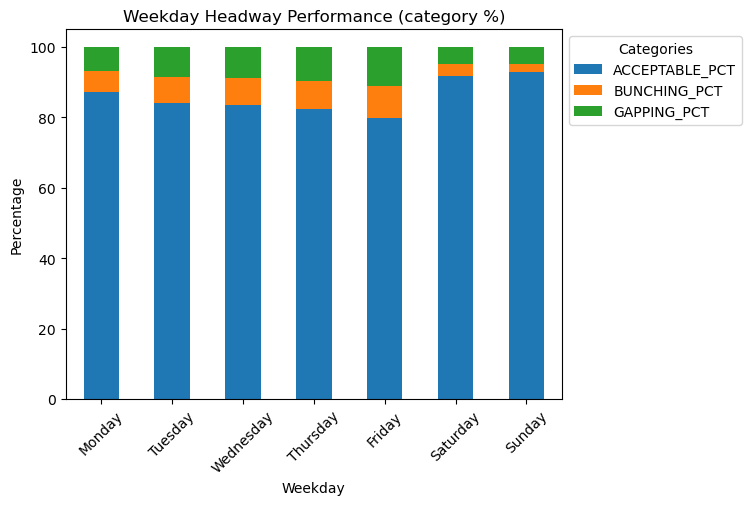

In [121]:
# Hour Adherence graph
ax = (weekday_hdwy_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
                ).sort_index().plot(kind='bar', stacked=True)

ax.set(title = 'Weekday Headway Performance (category %)',
        xlabel = 'Weekday',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)

#### No trips were made during the hours of 2 and 3

# 4) How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

### Adherence by Operpator

In [150]:
# Create new df for Adherence columns grouped by Operator
operator_totals = (
    wego.groupby('OPERATOR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT',
           'ADJUSTED_EARLY_COUNT', 'HDWY_BUNCHING',
           'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
         .sum()
)

In [151]:
# Create new total column for each row
operator_totals['ADH_TOTALS'] = (operator_totals[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT',
           'ADJUSTED_EARLY_COUNT']].sum(axis=1))
operator_totals['HDWY_TOTALS'] = (operator_totals[['HDWY_BUNCHING',
           'HDWY_ACCEPTABLE', 'HDWY_GAPPING']].sum(axis=1))

In [161]:
# Create new percentage column for each category
operator_totals.loc[:, 'ONTIME_PCT'] = round(operator_totals['ADJUSTED_ONTIME_COUNT'] / 
                                             operator_totals['ADH_TOTALS'] * 100, 1)
operator_totals.loc[:, 'EARLY_PCT'] = round(operator_totals['ADJUSTED_EARLY_COUNT'] /
                                            operator_totals['ADH_TOTALS'] * 100, 1)
operator_totals.loc[:, 'LATE_PCT'] = round(operator_totals['ADJUSTED_LATE_COUNT'] /
                                           operator_totals['ADH_TOTALS'] * 100, 1)
operator_totals.loc[:, 'BUNCHING_PCT'] = round(operator_totals['HDWY_BUNCHING'] /
                                               operator_totals['HDWY_TOTALS'] * 100, 1)
operator_totals.loc[:, 'ACCEPTABLE_PCT'] = round(operator_totals['HDWY_ACCEPTABLE'] /
                                                 operator_totals['HDWY_TOTALS'] * 100, 1)
operator_totals.loc[:, 'GAPPING_PCT'] = round(operator_totals['HDWY_GAPPING'] /
                                              operator_totals['HDWY_TOTALS'] * 100, 1)

In [166]:
(
    operator_totals
            .loc[operator_totals['ADH_TOTALS'] > 5]
            .nlargest(20, columns=['ONTIME_PCT', 'ADH_TOTALS'])
)

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,ADH_TOTALS,HDWY_TOTALS,ONTIME_PCT,EARLY_PCT,LATE_PCT,BUNCHING_PCT,ACCEPTABLE_PCT,GAPPING_PCT
OPERATOR,,,,,,,,,,,,,,
2294,45,0,0,0,28,0,45,28,100.0,0.0,0.0,0.0,100.0,0.0
1762,2294,23,16,103,1420,30,2333,1553,98.3,0.7,1.0,6.6,91.4,1.9
1597,252,6,0,1,150,1,258,152,97.7,0.0,2.3,0.7,98.7,0.7
1706,43,0,1,5,32,0,44,37,97.7,2.3,0.0,13.5,86.5,0.0
2639,202,2,3,3,117,0,207,120,97.6,1.4,1.0,2.5,97.5,0.0
409,2310,61,9,25,1657,33,2380,1715,97.1,0.4,2.6,1.5,96.6,1.9
2573,400,12,0,10,313,26,412,349,97.1,0.0,2.9,2.9,89.7,7.4
1566,2135,48,17,32,1799,4,2200,1835,97.0,0.8,2.2,1.7,98.0,0.2
2355,508,11,5,16,333,7,524,356,96.9,1.0,2.1,4.5,93.5,2.0


In [165]:
(
    operator_totals
            .loc[operator_totals['HDWY_TOTALS'] > 5]
            .nlargest(20, columns=['ACCEPTABLE_PCT', 'HDWY_TOTALS'])
)

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,ADH_TOTALS,HDWY_TOTALS,ONTIME_PCT,EARLY_PCT,LATE_PCT,BUNCHING_PCT,ACCEPTABLE_PCT,GAPPING_PCT
OPERATOR,,,,,,,,,,,,,,
2294,45,0,0,0,28,0,45,28,100.0,0.0,0.0,0.0,100.0,0.0
2494,31,7,1,0,28,0,39,28,79.5,2.6,17.9,0.0,100.0,0.0
2472,22,1,0,0,20,0,23,20,95.7,0.0,4.3,0.0,100.0,0.0
3118,14,6,4,0,20,0,24,20,58.3,16.7,25.0,0.0,100.0,0.0
3077,7,5,0,0,10,0,12,10,58.3,0.0,41.7,0.0,100.0,0.0
2313,9,1,0,0,8,0,10,8,90.0,0.0,10.0,0.0,100.0,0.0
2377,9,1,0,0,7,0,10,7,90.0,0.0,10.0,0.0,100.0,0.0
1597,252,6,0,1,150,1,258,152,97.7,0.0,2.3,0.7,98.7,0.7
1566,2135,48,17,32,1799,4,2200,1835,97.0,0.8,2.2,1.7,98.0,0.2
